# Evaluation of evidence retrieval: Hodgkin Lymphoma (retrospective)

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

#plt.style.use("../thesis.mplstyle")

In [2]:
OVERWRITE_LATEX_OUTPUT = True

In [3]:
GUIDELINE_ID = "hodgkin-lymphom"
SCREENING_TF_MIN = "01/01/2011"
SCREENING_TF_MAX = "11/30/2019"  # last included document is from November 2019

In [4]:
PATH_PREFIX = "hodgkin_lymphoma_retro"
PATH_GGPONC_LITERATURE = Path("../data/screening/ggponc_v2.1_2023_03_30_literature.csv")
PATH_RIS_CONTENT = Path(f"../data/screening/{PATH_PREFIX}/ris_with_matched_ids.csv")
PATH_QUERY_RESULT = Path(f"../data/screening/{PATH_PREFIX}/retrieved_evidence.parquet")
PATH_UNSCREENED_HQ = Path(f"../data/screening/{PATH_PREFIX}/unscreened_hq.csv")
PATH_LATEX_TABLE_OUTPUT = Path(
    f"../thesis/from_python/tables/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_PLOT_OUTPUT = Path(
    f"../thesis/from_python/figures/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

## Screened evidence

In [5]:
import pandas as pd

In [6]:
df_s = pd.read_csv(
    PATH_RIS_CONTENT,
    parse_dates=["publication_date", "article_date_api"],
).astype({"pm_id": "Int64"})

In [7]:
import ast

df_s["publication_types"] = df_s["publication_types"].apply(ast.literal_eval)

In [8]:
pd.crosstab(df_s["is_included"], df_s["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_included,,,
False,26,3,29
True,9,8,17
All,35,11,46


In [9]:
pd.crosstab(df_s["is_relevant"], df_s["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_relevant,,,
False,18,1,19
True,17,10,27
All,35,11,46


## Retrieved Evidence

In [10]:
from api.models import EvidenceQuery
from api.utils import query_api_for_evidence, evidence_to_df

In [11]:
from evaluation.fetching import pm_id_to_publication_date
from evaluation.matching import is_in_ggponc
from tqdm.auto import tqdm
import os
from requests.exceptions import ConnectionError

if PATH_QUERY_RESULT.exists():
    df_query = pd.read_parquet(PATH_QUERY_RESULT).astype({"pm_id": "Int64"})
else:
    query = EvidenceQuery(guideline_ids=[GUIDELINE_ID])
    try:
        # fetch evidence from API
        print("Fetching evidence from API")
        evidence = query_api_for_evidence(query=query)
        df_query = evidence_to_df(evidence)
        df_query["guideline_id"] = GUIDELINE_ID
        print("Done.")

        # retrieve exact article dates from Pubmed API
        tqdm.pandas(desc="Fetching article dates")
        df_query["article_date_api"] = pd.to_datetime(
            df_query["pm_id"].progress_apply(
                lambda pm_id: pm_id_to_publication_date(
                    pm_id=pm_id,
                    email="pwullenweber@mac.com",
                    api_key=os.environ.get("PUBMED_API_KEY"),
                    cache_path="../data/screening/pm_id_to_entrez_xml.json",
                )
            )
        )

        # exclude articles outside of screening timeframe
        df_query["publication_date_combined"] = df_query["article_date_api"].fillna(
            df_query["publication_date"]
        )
        df_query = df_query.query(
            "publication_date_combined >= @SCREENING_TF_MIN & publication_date_combined <= @SCREENING_TF_MAX"
        )

        # check presence in GGPONC
        df_ggponc = (
            pd.read_csv(PATH_GGPONC_LITERATURE)
            .astype({"pm_id": "Int64"})
            .query("guideline_id == @GUIDELINE_ID")
        )
        ggponc_pm_ids = set(df_ggponc["pm_id"].dropna())
        ggponc_titles = set(df_ggponc["title"])

        tqdm.pandas(desc="Checking for presence in GGPONC")
        df_query = df_query.progress_apply(  # type: ignore
            lambda row: is_in_ggponc(
                row=row, ggponc_pm_ids=ggponc_pm_ids, ggponc_titles=ggponc_titles
            ),
            axis=1,
        )

        df_query.to_parquet(PATH_QUERY_RESULT)
    except ConnectionError:
        print("Can't connect to the API, is it running?")

Fetching evidence from API
Done.


Fetching article dates:   0%|          | 0/1489 [00:00<?, ?it/s]

Couldn't find article date for 35584865
Couldn't find article date for 33539742
Couldn't find article date for 34597375
Couldn't find article date for 33512412
Couldn't find article date for 34048679
Couldn't find article date for 33770483
Couldn't find article date for 33820822
Couldn't find article date for 34477818
Couldn't find article date for 34048680
Couldn't find article date for 32352505
Couldn't find article date for 33113552
Couldn't find article date for 33037024
Couldn't find article date for 32853585
Couldn't find article date for 32060584
Couldn't find article date for 31945149
Couldn't find article date for 31132094
Couldn't find article date for 30233121
Couldn't find article date for 30290903
Couldn't find article date for 28604477
Couldn't find article date for 27332902
Couldn't find article date for 27869096
Couldn't find article date for 27007004
Couldn't find article date for 25901426
Couldn't find article date for 25802695
Couldn't find article date for 24567515


Checking for presence in GGPONC:   0%|          | 0/333 [00:00<?, ?it/s]

In [12]:
pd.crosstab(df_query["source"], df_query["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
source,,,
Civic,2,0,2
ClinicalTrials,136,0,136
Pubmed,60,22,82
Trialstreamer,82,31,113
All,280,53,333


In [13]:
pd.crosstab(df_s["is_included"], df_s["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
is_included,,,
False,19,10,29
True,1,16,17
All,20,26,46


In [14]:
pd.crosstab(df_s["is_relevant"], df_s["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
is_relevant,,,
False,19,0,19
True,1,26,27
All,20,26,46


## Retrieval Evaluation using the Pubmed data

For the evaluation, we only look at results retrieved from Pubmed:

In [15]:
df_r = df_query.query("source == 'Pubmed'").copy()

Furthermore, we consider all results that we can retrieve from GGPONC as having been screened and included, thus making them relevant. We therefor add these records to the dataframe containing the screened records:

In [16]:
from evaluation.matching import add_unscreened_ggponc_citations

In [17]:
df_s_with_ggponc = add_unscreened_ggponc_citations(df_s, df_r)

In [18]:
from evaluation.metrics import FILTERS_SCREENED, FILTERS_RETRIEVED

In [19]:
from evaluation.metrics import run_evaluation

metrics = run_evaluation(
    df_s_with_ggponc,
    df_r,
    filters_screened=FILTERS_SCREENED,
    filters_retrieved=FILTERS_RETRIEVED,
    col_id="pm_id",
    col_relevant="is_relevant",
    compute_combinations=False,
)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

### All evidence with a Pubmed ID

In [20]:
from evaluation.plotting import draw_venn_rsi

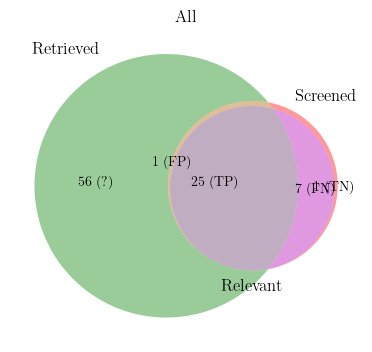

In [21]:
draw_venn_rsi(
    title="All",
    ids_retrieved=metrics["All"]["All"]["ids_retrieved"],
    ids_screened=metrics["All"]["All"]["ids_screened"],
    ids_screened_relevant=metrics["All"]["All"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [22]:
from evaluation.metrics import metrics_to_df, highlight_metrics

In [23]:
highlight_metrics(
    metrics_to_df(metrics["All"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.9615,0.7812,0.862100,25,1,7,1,56,82,34,32
Is RCT,0.9375,0.4688,0.625000,15,1,17,1,34,50,34,32
Non-empty Abstract,1.0000,0.7500,0.857100,24,0,8,2,50,74,34,32
Non-pediatric population,0.9565,0.6875,0.800000,22,1,10,1,48,71,34,32
Phase >= 2,0.9286,0.4062,0.565200,13,1,19,1,21,35,34,32
Phase >= 3,1.0000,0.3750,0.545500,12,0,20,2,16,28,34,32
Sample Size >= 5,0.9600,0.7500,0.842100,24,1,8,1,54,79,34,32
Sample Size >= 10,0.9583,0.7188,0.821400,23,1,9,1,53,77,34,32
Sample Size >= 15,0.9583,0.7188,0.821400,23,1,9,1,53,77,34,32
Known Intervention,0.9600,0.7500,0.842100,24,1,8,1,44,69,34,32


### RCTs only

/Users/paul/Documents/HPI/nge-browser-data-integration/.venv/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


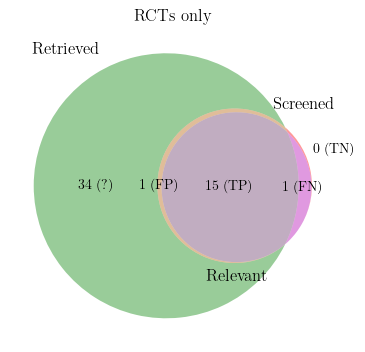

In [24]:
draw_venn_rsi(
    title="RCTs only",
    ids_retrieved=metrics["Only RCTs"]["Is RCT"]["ids_retrieved"],
    ids_screened=metrics["Only RCTs"]["Is RCT"]["ids_screened"],
    ids_screened_relevant=metrics["Only RCTs"]["Is RCT"]["ids_screened_relevant"],
    add_pn_labels=True,
    label_offsets={"TN": (0.1, 0.1)},
);

In [25]:
highlight_metrics(
    metrics_to_df(metrics["Only RCTs"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.9375,0.9375,0.937500,15,1,1,0,66,82,17,16
Is RCT,0.9375,0.9375,0.937500,15,1,1,0,34,50,17,16
Non-empty Abstract,1.0000,0.8750,0.933300,14,0,2,1,60,74,17,16
Non-pediatric population,0.9333,0.8750,0.903200,14,1,2,0,56,71,17,16
Phase >= 2,0.9091,0.6250,0.740700,10,1,6,0,24,35,17,16
Phase >= 3,1.0000,0.5625,0.720000,9,0,7,1,19,28,17,16
Sample Size >= 5,0.9375,0.9375,0.937500,15,1,1,0,63,79,17,16
Sample Size >= 10,0.9375,0.9375,0.937500,15,1,1,0,61,77,17,16
Sample Size >= 15,0.9375,0.9375,0.937500,15,1,1,0,61,77,17,16
Known Intervention,0.9375,0.9375,0.937500,15,1,1,0,53,69,17,16


#### Hand-picked Filter Combinations

In [26]:
from evaluation.metrics import build_filter_combinations_table

In [27]:
combinations_table, metrics_combinations = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc,
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics.tex",
    overwrite_latex_output=OVERWRITE_LATEX_OUTPUT,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=2]",
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
combinations_table, metrics_combinations = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc,
    stop_at_line=4,
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics_first_lines.tex",
    overwrite_latex_output=OVERWRITE_LATEX_OUTPUT,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=2]",
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

#### Remaining False Positives

In [29]:
ids_false_positives = (
    metrics_to_df(metrics_combinations["Only RCTs"], drop_columns=[])
    .sort_values(["Recall", "Precision", "Retrieved"], ascending=[False, False, True])
    .iloc[0]["Ids_fp"]
)

In [30]:
false_positives = df_s_with_ggponc[
    df_s_with_ggponc["pm_id"].apply(lambda pm_id: pm_id in ids_false_positives)
]

In [31]:
false_positives["exclusion_reason"].value_counts()

excluded_abstract    1
Name: exclusion_reason, dtype: int64

## Missing RCTs

We should be able to find all included RCTs. If not, we need to find out why we did not retrieve them:

In [32]:
from api.utils import query_api_for_concepts, concepts_to_df
from api.models import ConceptsQuery

missing_rcts_df = concepts_to_df(
    query_api_for_concepts(
        ConceptsQuery(
            source="pubmed",
            ids=[int(pm_id) for pm_id in metrics["Only RCTs"]["All"]["ids_fn"]],
            kind="population",
        )
    )
)

Looks like it is due to vague population concepts:

In [33]:
from evaluation.metrics import prepare_missing_rcts_concepts_df

missing_rcts_concepts_df = prepare_missing_rcts_concepts_df(
    missing_rcts_df=missing_rcts_df
)
missing_rcts_concepts_df

UMLS Term
Pubmed ID CUI                                 
27217453  C3665472                Chemotherapy
          C1171194      Fertility Preservation
          C0024299                    Lymphoma
          C0085215  Ovarian Failure, Premature
          C0013216             Pharmacotherapy

## Unscreened High Quality Evidence

For this section, we consider all sources. However, we exclude duplicates that are both in Pubmed and in Trialstreamer:

In [34]:
df_query.reset_index(drop=True, inplace=True)
df_query = df_query[
    (
        ~df_query.sort_values(["pm_id", "source"]).duplicated(
            subset="pm_id", keep="first"
        )
    )
    | (df_query["pm_id"].isnull())
]

We then set boolean flags with which we can filter out the already screened evidence:

In [35]:
from evaluation.matching import check_for_matches_in_screened

df_query = check_for_matches_in_screened(
    df_query=df_query, df_screened=df_s_with_ggponc
)

In [36]:
df_query_unscreened = df_query.query("is_screened == False")

In [37]:
pd.crosstab(
    df_query_unscreened["source"],
    df_query_unscreened["has_title_match_in_screened"],
    margins=True,
)

has_title_match_in_screened,False,True,All
source,,,
Civic,2,0,2
ClinicalTrials,134,0,134
Pubmed,56,0,56
Trialstreamer,60,1,61
All,252,1,253


In [38]:
FILTER_HQ = (
    "is_in_ggponc == False"
    "&"
    "has_title_match_in_screened == False"
    "&"
    "has_pediatric_population == False"
    "&"
    "("
    "(source == 'ClinicalTrials' & phase_int >= 3 & results_available)"
    "|"
    "(source == 'Civic' & evidence_rating >= 4)"
    "|"
    "(source == 'Pubmed' & abstract.str.len() > 1 & is_rct == True & phase_int >= 2)"
    ")"
)

In [39]:
df_query_unscreened_hq = df_query_unscreened.query(FILTER_HQ)

manual_review = df_query_unscreened_hq.sort_values(
    ["source", "publication_date"], ascending=False
)
manual_review

,title,abstract,publication_date,source,pm_id,pmc_id,nct_id,referenced_nct_ids,referenced_pm_ids,phase,...,interventions_unknown,interventions_known,cpg_matches_population,cpg_matches_intervention,guideline_id,article_date_api,publication_date_combined,is_in_ggponc,is_screened,has_title_match_in_screened
122,FDA's and EMA's approval of brentuximab vedoti...,ECHELON-1 study is a randomized open-labeled c...,2019-09-01,Pubmed,31166030,None,None,[],[],Phase III,...,[],"[Drug therapy, Chemo, Brentuximab]",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2019-06-17,2019-06-17,False,False,False
129,Addition of Low-Dose Decitabine to Anti-PD-1 A...,PURPOSE\n\n\nAnti-programmed death-1 (PD-1) mo...,2019-06-01,Pubmed,31039052,None,None,"[NCT02961101, NCT03250962]",[],Phase II,...,"[decitabine, camrelizumab]","[Anti-PD1 Monoclonal Antibody, Single Agent Th...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2019-04-30,2019-04-30,False,False,False
130,Brentuximab Vedotin plus Chemotherapy in North...,PURPOSE\n\n\nTo evaluate safety and efficacy o...,2019-03-01,Pubmed,30617130,None,None,[NCT01712490],[],Phase III,...,[],"[ABVD-I protocol, Drug therapy, Doxorubicin, B...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2019-01-07,2019-01-07,False,False,False
135,Cost-effectiveness of brentuximab vedotin plus...,OBJECTIVE\n\n\nThe ECHELON-1 trial demonstrate...,2019-02-01,Pubmed,30375910,None,None,[],[],Phase III,...,[],"[ABVD-I protocol, Drug therapy, Doxorubicin, B...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2018-12-10,2018-12-10,False,False,False
136,PET-adapted treatment for newly diagnosed adva...,"BACKGROUND\n\n\nIncreased-dose bleomycin, etop...",2019-02-01,Pubmed,30658935,None,None,[NCT01358747],[],Phase III,...,[],"[Bleomycin, BEACOPP Regimen, Doxorubicin, Pred...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2019-01-15,2019-01-15,False,False,False
150,Phase-I and randomized phase-II trial of panob...,This phase-I/phase-II study evaluated panobino...,2018-04-01,Pubmed,28792260,None,None,[],[],Phase II,...,"[Carboplatin/Etoposide/Ifosfamide, panobinostat]","[Ifosfamide, Etoposide, Carboplatin]",[hodgkin-lymphom],"[oesophaguskarzinom, dlbcl, mammakarzinom, akt...",hodgkin-lymphom,2017-08-09,2017-08-09,False,False,False
156,Incorporation of brentuximab vedotin into firs...,BACKGROUND\n\n\nA high proportion of patients ...,2017-12-01,Pubmed,29133014,None,None,[],[],phase 3,...,[],"[Vincristine, Cyclophosphamide, Doxorubicin, P...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2017-11-10,2017-11-10,False,False,False
172,Checkpoint inhibitors and radiation treatment ...,BACKGROUND\n\n\nPatients with classical Hodgki...,2017-02-01,Pubmed,27704149,None,None,[],[],phase II,...,[],"[Anti-PD1 Monoclonal Antibody, Immune Checkpoi...",[hodgkin-lymphom],"[oesophaguskarzinom, chronisch-lymphatische-le...",hodgkin-lymphom,2016-10-04,2016-10-04,False,False,False
177,Quality of life results from a phase 3 study o...,Brentuximab vedotin (BV) significantly improve...,2016-12-01,Pubmed,27649689,None,None,[],[],Phase III,...,[Sham Treatment],[Brentuximab],[hodgkin-lymphom],"[adulte-weichgewebesarkome, komplementaermediz...",hodgkin-lymphom,2016-09-21,2016-09-21,False,False,False
185,Prognostic relevance of DHAP dose-density in r...,Only 50% of patients with relapsed Hodgkin lym...,2016-05-01,Pubmed,26693800,None,None,[],[],Phase III,...,[SCT],"[High Dose Chemotherapy, Transplantation of au...",[hodgkin-lymphom],"[chronisch-lymphatische-leukaemie-cll, aktinis...",hodgkin-lymphom,2015-12-23,2015-12-23,False,False,False


In [40]:
df_query_unscreened_hq.to_csv(PATH_UNSCREENED_HQ, index=False)

### Latex Output

In [41]:
from evaluation.metrics import remove_last_cline_from_tex_table

#### Missing RCTs

In [42]:
if OVERWRITE_LATEX_OUTPUT:
    missing_rcts_concepts_df[["UMLS Term"]].style.format(escape="latex").to_latex(
        PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex",
        hrules=True,
        clines="skip-last;data",
    )
    remove_last_cline_from_tex_table(PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex")

#### Retrieval Metrics

In [43]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc in metrics.keys():
        highlight_metrics(
            metrics_to_df(
                metrics[subset_screened_desc],
                drop_zero_tp=False,
                use_abbreviations=True,
            )
            .head(len(FILTERS_RETRIEVED))
            .drop(columns=["Scr.", "Rel."])
        ).applymap_index(lambda v: "font-weight: bold;", axis="columns").to_latex(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex",
            hrules=True,
            convert_css=True,
            siunitx=True,
            clines="all;data",
            column_format="lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=1]S[table-format=2]S[table-format=2]",
        )
        remove_last_cline_from_tex_table(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex"
        )

/Users/paul/Documents/HPI/nge-browser-data-integration/.venv/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


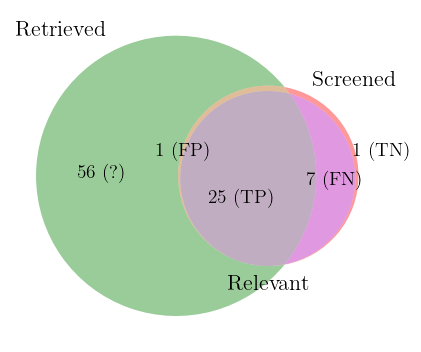

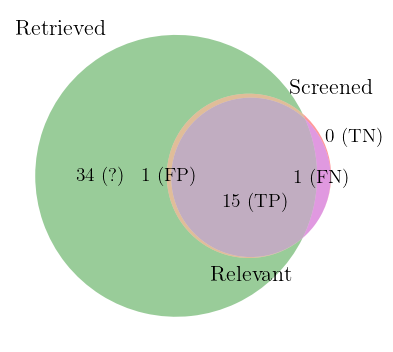

In [44]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc, subset_retrieved_desc in zip(
        ["All", "Only RCTs"], ["All", "Is RCT"]
    ):
        fig, ax = draw_venn_rsi(
            title=None,
            ids_retrieved=metrics[subset_screened_desc][subset_retrieved_desc][
                "ids_retrieved"
            ],
            ids_screened=metrics[subset_screened_desc][subset_retrieved_desc][
                "ids_screened"
            ],
            ids_screened_relevant=metrics[subset_screened_desc][subset_retrieved_desc][
                "ids_screened_relevant"
            ],
            add_pn_labels=True,
            circle_label_size=16,
            label_size=14,
            label_offsets={"TP": (0.05, -0.1), "TN": (0.1, 0.1)},
        )
        fig.savefig(
            PATH_LATEX_PLOT_OUTPUT
            / f"venn3_screened_found_included_{subset_screened_desc}.pdf",
        )

#### Screening Data

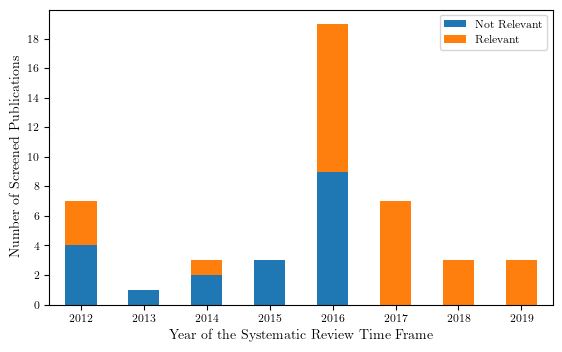

In [45]:
from evaluation.plotting import draw_docs_by_publication_date

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_by_publication_date(
        df_screened=df_s,
        col_date="publication_date",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"screened_by_publication_year.pdf",
    )

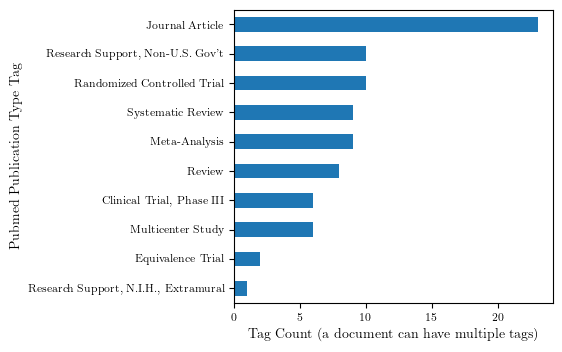

In [46]:
from evaluation.plotting import draw_docs_publication_types

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_publication_types(
        df_screened=df_s,
        n_most_common=10,
        col_ptypes="publication_types",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"publication_types_included.pdf",
    )

#### Retrieved Data

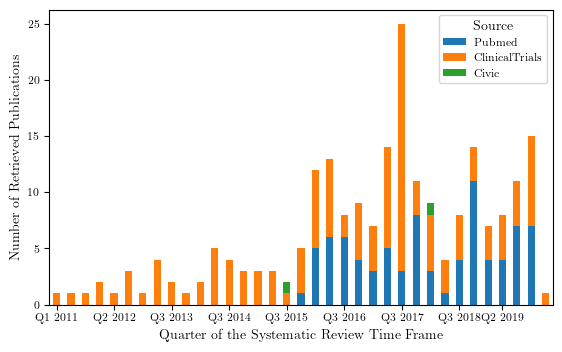

In [47]:
from evaluation.plotting import set_size
from matplotlib.dates import AutoDateLocator

if OVERWRITE_LATEX_OUTPUT:
    monthly_retrievals = (
        df_query.query("source != 'Trialstreamer'")
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "source"])
        .size()
        .unstack()
        .rename(index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}")
        .rename_axis("Source", axis=1)
    )[["Pubmed", "ClinicalTrials", "Civic"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    monthly_retrievals.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Quarter of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["MONTHLY"] = 6
    ax.xaxis.set_major_locator(locator)
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrievals_by_source.pdf")

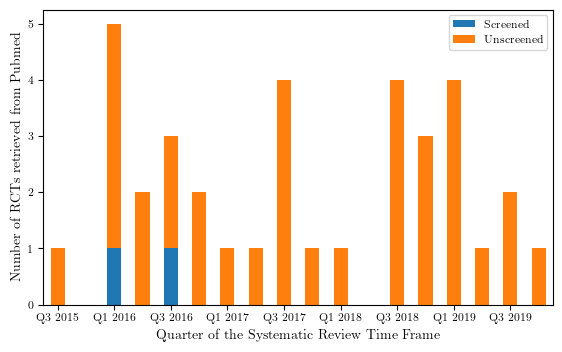

In [48]:
from matplotlib.ticker import MaxNLocator

if OVERWRITE_LATEX_OUTPUT:
    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

    monhtly_retrieved_vs_screened_pm = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True & is_in_ggponc == False")
        .merge(df_s[["pm_id", "is_included"]], on="pm_id", how="left", indicator=True)
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "_merge"])
        .size()
        .unstack()[["both", "left_only"]]
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={"left_only": "Unscreened", "both": "Screened"},
        )
        .rename_axis(None, axis=1)
    )

    monhtly_retrieved_vs_screened_pm.plot(
        kind="bar",
        stacked=True,
        ylabel="Number of RCTs retrieved from Pubmed",
        xlabel="Quarter of the Systematic Review Time Frame",
        ax=ax,
        rot=0,
    )

    locator = AutoDateLocator()
    locator.intervald["MONTHLY"] = 6
    ax.xaxis.set_major_locator(locator)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrieved_vs_screened_rcts.pdf")

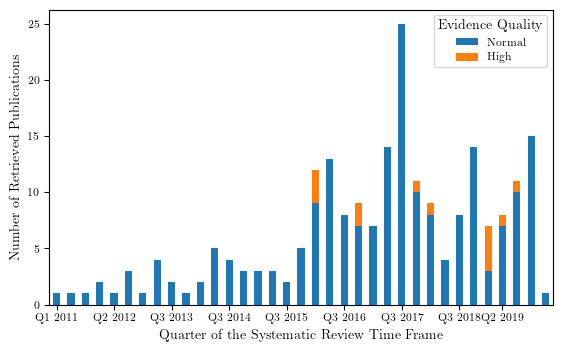

In [49]:
if OVERWRITE_LATEX_OUTPUT:
    df_query.loc[df_query.query(FILTER_HQ).index, "is_hq"] = True
    df_query["is_hq"] = df_query["is_hq"].fillna(False)

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    df_query.query("source != 'Trialstreamer'").groupby(
        [pd.Grouper(key="publication_date_combined", freq="3M"), "is_hq"]
    ).size().unstack().rename(
        index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
        columns={True: "High", False: "Normal"},
    ).rename_axis(
        "Evidence Quality", axis=1
    ).plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Quarter of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["MONTHLY"] = 6
    ax.xaxis.set_major_locator(locator)

/var/folders/zp/lynn4fvn4_56y9lv5919h_rw0000gn/T/ipykernel_22681/2388801778.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_query.query("source == 'Pubmed' & is_rct_pt == True")


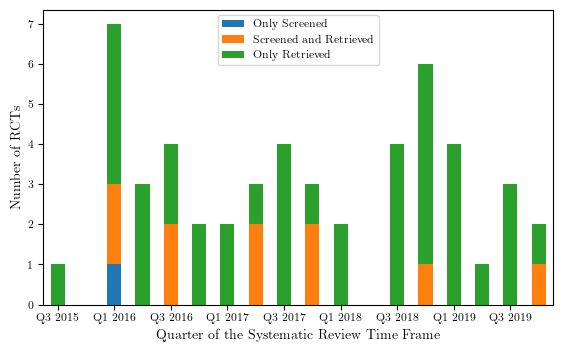

In [50]:
if OVERWRITE_LATEX_OUTPUT:
    df_merged = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True")
        .dropna(subset="pm_id")
        .merge(
            df_s.query("is_rct_api == True")[
                ["pm_id", "publication_date", "is_included"]
            ].dropna(subset="pm_id"),
            on="pm_id",
            how="outer",
            indicator=True,
        )
    )
    df_merged["common_publication_date"] = df_merged[
        "publication_date_combined"
    ].fillna(df_merged["publication_date_y"])

    montly_retrieved_vs_screened = (
        df_merged.groupby(
            [pd.Grouper(key="common_publication_date", freq="3M"), "_merge"]
        )
        .size()
        .unstack()
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={
                "left_only": "Only Retrieved",
                "both": "Screened and Retrieved",
                "right_only": "Only Screened",
            },
        )
        .rename_axis(None, axis=1)
    )[["Only Screened", "Screened and Retrieved", "Only Retrieved"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    montly_retrieved_vs_screened.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Quarter of the Systematic Review Time Frame",
        ylabel="Number of RCTs",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"yearly_retrieved_vs_screened_rcts.pdf")